#### Beam Statistics Report with Apertures Notebook
Author: Paul Moeller
Edited by N. Goldring and B. Nash May 2022

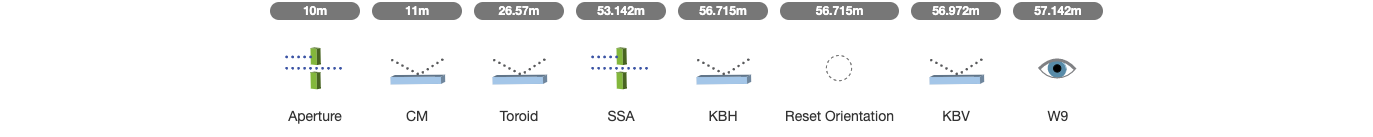

In [1]:
from IPython.display import Image
# original shadow simulation: https://www.sirepo.com/shadow#/beamline/x0UKaW70
display(Image('Beamline-with-mirrors.png'))

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from Shadow.ShadowPreprocessorsXraylib import prerefl, pre_mlayer, bragg
from pykern import pkjson
from pykern.pkcollections import PKDict
from pykern.pkdebug import pkdc, pkdp
from sirepo.template import transfer_mat_bl
from srxraylib.sources import srfunc
import Shadow
import math
import numpy
import re
import scipy.linalg as sla
import copy

import os
try:
    __IPYTHON__
    import sys
    del sys.argv[1:]
except:
    pass

In [3]:
alpha = 0         # coordinate system rotation angle [rad]
epsilon = 1e-06   # offset small parameter for transfer matrix calculation 
energy = 2500.0   # photon energy [eV]

In [4]:
# from https://github.com/radiasoft/rslight/blob/main/Gaussian/gauss_apert-01.py

#  Propagate a 4x4 covariance matrix Sigma through a Gaussian aperture of (Gaussian, not not hard-edge)
#  size parameters a_gx, a_gy
#  NB:  assumed ordering of the variables is x, y, theta_x, theta_y
def gauss_apert_4x4(Sigma, lambda_rad, a_gx, a_gy):
    """
    Compute new sigma matrix after passing through a Gaussian aperture.
    
    Sigma: second moment matrix
    lambda_rad: radiation wavelength [m]
    a_gx: effective Gaussian aperture sigma (x-component)
    a_gy: effective Gaussian aperture sigma (y-component)
    
    Note: assumed ordering of the variables is x, y, theta_x, theta_y
    """
    
    Sigma_inv = sla.inv(Sigma)
    A = 1.0 *Sigma_inv[0:2,0:2]
    B = 1.0 *Sigma_inv[0:2,2:4]
    C = numpy.transpose(B)
    D = 1.0 *Sigma_inv[2:4,2:4]

    A_A = numpy.zeros([2,2], dtype=numpy.float32)
    A_A[0,0] = 2. /a_gx**2
    A_A[1,1] = 2. /a_gy**2

    D_inv = sla.inv(D)
    D_A_inv = numpy.zeros([2,2], dtype=numpy.float32)
    D_A_inv[0,0] = 1. /a_gx**2
    D_A_inv[1,1] = 1. /a_gy**2
    D_A_inv *= lambda_rad**2 /(8. *numpy.pi *numpy.pi)

    D_f = sla.inv(D_inv +D_A_inv)
    BDi = numpy.matmul(B, D_inv)
    DiC = numpy.matmul(D_inv, C)  #  == numpy.transpose(BDi)
    C_f = numpy.matmul(D_f, DiC)
    B_f = numpy.transpose(C_f)    #  ==  numpy.matmul(BDi, D_f)
    A_f = A +A_A -numpy.matmul(BDi, C) +numpy.matmul(BDi, numpy.matmul(D_f, DiC))

    Sigma_inv[0:2,0:2] = 1.0 *A_f
    Sigma_inv[0:2,2:4] = 1.0 *B_f
    Sigma_inv[2:4,0:2] = 1.0 *C_f
    Sigma_inv[2:4,2:4] = 1.0 *D_f

    return sla.inv(Sigma_inv)

In [5]:
help(gauss_apert_4x4)

Help on function gauss_apert_4x4 in module __main__:

gauss_apert_4x4(Sigma, lambda_rad, a_gx, a_gy)
    Compute new sigma matrix after passing through a Gaussian aperture.
    
    Sigma: second moment matrix
    lambda_rad: radiation wavelength [m]
    a_gx: effective Gaussian aperture sigma (x-component)
    a_gy: effective Gaussian aperture sigma (y-component)
    
    Note: assumed ordering of the variables is x, y, theta_x, theta_y



In [6]:
def rays_sigma(rays, idx):
    """
    Compute the sigma value of a given ray coordinate.
    
    rays: Shadow ray object
    idx: index of ray element
    """
    
    return numpy.sqrt(numpy.mean(rays[:, idx] ** 2))

def create_sigma_matrix():
    """
    Creates a sigma matrix from Shadow source parameters.
    """
    
    source = Shadow.Source()
    beam = Shadow.Beam()
    source.NPOINT = 10000
    source.ISTAR1 = 567656
    source.SIGMAX = 0.012526741356
    source.SIGMAZ = 0.001341640786
    source.EPSI_X = 5.500000000000001e-08
    source.EPSI_Z = 8e-10
    source.BENER = 3.0
    source.EPSI_DX = 0.0
    source.EPSI_DZ = 0.0
    source.F_POL = 3
    source.HDIV1 = 0.0005
    source.HDIV2 = 0.0005
    source.VDIV1 = 1.0
    source.VDIV2 = 1.0
    source.F_PHOT = 0
    source.FSOURCE_DEPTH = 4
    source.F_COLOR = 3
    source.R_MAGNET = 25.0173071398614
    source.PH1 = 2500.0
    source.PH2 = 2500.001
    source.FDISTR = 4
    source.R_ALADDIN = source.R_MAGNET * 100
    beam.genSource(source)
    rays = beam.rays
    sigmax = rays_sigma(rays, 0)
    sigdix = rays_sigma(rays, 3)
    sigmaz = rays_sigma(rays, 2)
    sigdiz = rays_sigma(rays, 5)
    res = numpy.matrix([
        [sigmax ** 2, 0, 0, 0],
        [0, sigdix ** 2, 0, 0],
        [0, 0, sigmaz ** 2, 0],
        [0, 0, 0, sigdiz ** 2],
    ])
    pkdp('sigma_mat:\n{}', res)
    return res

def apply_aperture(oe, mat):
    # def apply_aperture(oe, beam, mat):
    """
    Transform to correct phase space ordering and apply Gaussian 
    aperture formula to produce propagated sigma matrix.
    oe: Shadow aperture optical element object
    mat: input sigma matrix in the format x, x', y, y'
    """
    
    pkdp('aperture size [m]: {} x {}',
         oe.RX_SLIT[0] * 1e-2,
         oe.RZ_SLIT[0] * 1e-2)
    Pmat = numpy.array([
        [1.0, 0.0, 0.0, 0.0],
        [0.0, 0.0, 1.0, 0.0],
        [0.0, 1.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, 1.0]])
    res = gauss_apert_4x4(
        # Convert Sigma to x, y, xp, yp, via Pmat Sigma Pmat (since Pmat is symmetric)
        numpy.matmul(numpy.matmul(Pmat, mat), Pmat),
        # wavelength [cm]
        1.2398419843320026 / energy * 1e-6 * 1e2,
        # aperture x, y [cm]
        oe.RX_SLIT[0],
        oe.RZ_SLIT[0],
    )
    return numpy.matmul(numpy.matmul(Pmat, res), Pmat)

def assert_no_lost_rays(beam):
    """
    Test to make sure no rays have been lost.
    beam: Shadow beam object
    """
    
    lost = []
    LOST_RAY_FLAG = 9
    for i in range(len(beam.rays)):
        if beam.rays[i][LOST_RAY_FLAG] != 1:
            lost.append(i)
    if len(lost):
        raise AssertionError(
            'Lost tracking particle(s) # {}'.format(
                ', '.join(str(v) for v in lost)),
        )

In [7]:
# def calculate_stats(pos, oe, beam):
#     """
    
#     beam: Shadow beam object with propagated rays
#     """
    
#     global alpha
    
#     #TODO(pjm): this calculates the Tmat for the constant sigma_mat
#     # need to compute the Tmat element by element instead
#     Tmat, x_prop_cen, xp_prop_cen, z_prop_cen, zp_prop_cen = transfer_mat_bl.tmat_calc(beam.duplicate(), epsilon)
#     res = Tmat * sigma_mat * numpy.transpose(Tmat)
#     pos += (oe.T_SOURCE if oe else 0)
#     if oe:
#         # oe.ALPHA is in radians after traceOE()
#         alpha = int(alpha + 180 / math.pi * oe.ALPHA) % 360
#     beam_stats.append(PKDict(
#         isRotated=True if alpha == 90 or alpha == 270 else False,
#         s=pos * 1e-2,
#         x=x_prop_cen,
#         xp=xp_prop_cen,
#         z=z_prop_cen,
#         zp=zp_prop_cen,
#         matrix=Tmat.tolist(),
#         sigma_mx=res.tolist(),
#         sigmax=math.sqrt(res[0, 0]) * 1e-2,
#         sigdix=math.sqrt(res[1, 1]),
#         sigmaz=math.sqrt(res[2, 2]) * 1e-2,
#         sigdiz=math.sqrt(res[3, 3]),
#     ))
#     if oe and oe.I_STOP[0] == 0 and oe.RX_SLIT[0] != 0 and oe.RZ_SLIT[0] != 0:
#         #TODO(pjm): the element is an aperture
#         # res2 = apply_aperture(oe, beam, res)
#         res2 = apply_aperture(oe, res)    # nick edit
#         #TODO(pjm): need to compute and save the new matrix with the aperture changes
#         pkdp('matrix before aperture:\n{}', res)
#         pkdp('matrix after aperture:\n{}', res2)
#     return pos

def calculate_stats(pos, oe, beam):
    """
    pos: position of element along optical axis [cm]
    oe: Shadow optical element object
    beam: Shadow beam object with propagated rays
    sigma_mat: sigma matrix
    """
    
    global alpha
    global sigma_mat
    
    #TODO(pjm): this calculates the Tmat for the constant sigma_mat
    # need to compute the Tmat element by element instead
    if oe and oe.I_STOP[0] == 0 and oe.RX_SLIT[0] != 0 and oe.RZ_SLIT[0] != 0:
        print('calculate stats should be processing aperture')
        #TODO(pjm): the element is an aperture
        # res2 = apply_aperture(oe, beam, res)
        res = sigma_mat
        res2 = apply_aperture(oe, res)
        sigma_mat = res2
        pkdp('sigma matrix (aperture): \n{}', sigma_mat)
        #TODO(pjm): need to compute and save the new matrix with the aperture changes
        pkdp('matrix before aperture:\n{}', res)
        pkdp('matrix after aperture:\n{}', res2)
    else:
        print('calculate stats should be processing oe not an aperture')
        Tmat, x_prop_cen, xp_prop_cen, z_prop_cen, zp_prop_cen = transfer_mat_bl.tmat_calc(beam.duplicate(), epsilon)
        res = Tmat * sigma_mat * numpy.transpose(Tmat)
        sigma_mat = res  # update sigma_mat
        pkdp('sigma matrix (regular element): \n{}', sigma_mat)
        pos += (oe.T_SOURCE if oe else 0)
        # if oe:
            # oe.ALPHA is in radians after traceOE()
        alpha = int(alpha + 180 / math.pi * oe.ALPHA) % 360
        beam_stats.append(PKDict(
            isRotated=True if alpha == 90 or alpha == 270 else False,
            s=pos * 1e-2,
            x=x_prop_cen,
            xp=xp_prop_cen,
            z=z_prop_cen,
            zp=zp_prop_cen,
            matrix=Tmat.tolist(),
            sigma_mx=res.tolist(),
            sigmax=math.sqrt(res[0, 0]) * 1e-2,
            sigdix=math.sqrt(res[1, 1]),
            sigmaz=math.sqrt(res[2, 2]) * 1e-2,
            sigdiz=math.sqrt(res[3, 3]),
        ))
    
    return pos

def divide_drift(pos, beam, count, distance, divisions=100):
    if distance < 1e-3:
        return
    for i in range(divisions):
        # beam = beam0      # check Python variable assignment (deepcopy?)
        oe = Shadow.OE()
        oe.DUMMY = 1.0
        oe.set_empty(ALPHA=0)
        oe.FWRITE = 3
        oe.T_IMAGE = 0.0
        oe.T_SOURCE = distance / divisions
        beam.traceOE(oe, count)
        count += 1
        pos = calculate_stats(pos, oe, beam)
    return pos

def process_stats():
    def compute_angx(x, z, xz, scale=1):
        x = numpy.array(x)
        z = numpy.array(z)
        xz = numpy.array(xz)
        return ((1/2) * numpy.arctan(2 * scale * xz / (x ** 2 - z ** 2))).tolist()

    def rotated_values(stats, field):
        if field == 'sigmaxz':
            return [-v.sigma_mx[0][2] if v.isRotated else v.sigma_mx[0][2] for v in stats]
        if field == 'sigmaxpzp':
            return [-v.sigma_mx[1][3] if v.isRotated else v.sigma_mx[1][3] for v in stats]
        if re.search('z', field):
            f = re.sub('z', 'x', field)
        else:
            f = re.sub('x', 'z', field)
        return [v[f] if v.isRotated else v[field] for v in stats]

    res = PKDict(
        s=[v.s for v in beam_stats],
    )
    for f in ('sigmax', 'sigdix', 'sigmaz', 'sigdiz', 'sigmaxz', 'sigmaxpzp', 'x', 'xp', 'z', 'zp'):
        res[f] = rotated_values(beam_stats, f)
    res.angxz = compute_angx(res.sigmax, res.sigmaz, res.sigmaxz, scale=1e-4)
    res.angxpzp = compute_angx(res.sigdix, res.sigdiz, res.sigmaxpzp)
    return res

def run_shadow_simulation():
    pkdp('starting shadow simulation')
    beam0 = transfer_mat_bl.create_mat_rays(epsilon, energy)
    pkdp('beam0.rays initial: \n{}', beam0.rays)
    pkdp('initial beam: {}', beam0)
    # pos = calculate_stats(0, None, beam0, sigma_mat)
    # print('pos:', pos)
    pos = divide_drift(0.0, beam0.duplicate(), 1, 1000.0, 10)
    pkdp('beam0.rays after divide drift 1: \n{}', beam0.rays)
    # 0.5 x 0.4 aperture [cm]
    oe = Shadow.OE()
    oe.DUMMY = 1.0
    oe.set_empty().set_screens()
    oe.I_SLIT[0] = 1
    oe.K_SLIT[0] = 0
    oe.I_STOP[0] = 0
    oe.RX_SLIT[0] = 1000000.75
    oe.RZ_SLIT[0] = 1000000.009
    oe.CX_SLIT[0] = 0.0
    oe.CZ_SLIT[0] = 0.0
    oe.FWRITE = 3
    oe.T_IMAGE = 0.0
    oe.T_SOURCE = 0
    # beam.traceOE(oe, 101)
    pkdp('beam0.rays before aperture calc stats: \n{}', beam0.rays)
    pos = calculate_stats(pos, oe, beam0.duplicate())
    pkdp('beam0.rays after aperture calc stats: \n{}', beam0.rays)

    pos = divide_drift(pos, beam0.duplicate(), 102, 100.0, 10)

    
    # # watchpoint
    # oe = Shadow.OE()
    # oe.DUMMY = 1.0
    # oe.set_empty()
    # oe.FWRITE = 3
    # oe.T_IMAGE = 0.0
    # oe.T_SOURCE = 0
    # # oe.set_empty(ALPHA=0)
    # beam.traceOE(oe, 708)
    # pos = calculate_stats(pos, oe, beam, sigma_mat)

    # assert_no_lost_rays(beam)
    return process_stats()

In [8]:
# enable and block print statements for trimming Shadow output

# Disable
def blockPrint():
    sys.stdout = open(os.devnull, 'w')

# Restore
def enablePrint():
    sys.stdout = sys.__stdout__


print('This will print')

blockPrint()
print("This won't")

enablePrint()
print("This will too")

This will print
This will too
 Generated          500  rays out of        10000
                   1000
                   1500
                   2000
                   2500
                   3000
                   3500
                   4000
                   4500
                   5000
                   5500
                   6000
                   6500
                   7000
                   7500
                   8000
                   8500
                   9000
                   9500
                  10000
 Exit from SOURCE
 Exit from SOURCE
 Call to RESET
 Exit from RESET
 Call to SETSOUR
 Exit from SETSOUR
 Call to IMREF
 Exit from IMREF
 Call to OPTAXIS
 Exit from OPTAXIS
 Call to MSETUP
 Exit from MSETUP
 Call to RESTART
 Exit from RESTART
 Call to MIRROR
 MIRROR1: Warning: Empty element (no mirr.xx file)
 Call to IMAGE
 Exit from IMAGE
 Call to DEALLOC
 Exit from DEALLOC
 Call to RESET
 Exit from RESET
 Call to SETSOUR
 Exit from SETSOUR
 Call to IMREF
 Exi

In [9]:
blockPrint()
beam_stats = []
sigma_mat = create_sigma_matrix()

print('sigma_mat:', sigma_mat)

/tmp/ipykernel_5256/495964986.py:52:create_sigma_matrix sigma_mat:
[[1.58006577e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 8.51153199e-08 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.85717959e-06 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 9.00306079e-09]]


In [10]:
stats = run_shadow_simulation()

/tmp/ipykernel_5256/1064154214.py:135:run_shadow_simulation starting shadow simulation
/tmp/ipykernel_5256/1064154214.py:137:run_shadow_simulation beam0.rays initial: 
[[ 0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
   9.99999999e-001  0.00000000e+000  9.99999999e-001 -3.98618112e-005
   1.84175847e-010  1.00000000e+000  1.26693269e+008  1.00000000e+000
   6.93139655e-310  6.93139655e-310  6.93139655e-310  6.93139655e-310
   6.93139551e-310  6.93139655e-310]
 [ 1.00000000e-006  0.00000000e+000  0.00000000e+000  0.00000000e+000
   9.99999999e-001  0.00000000e+000  9.99999999e-001 -3.25387520e-005
   3.05886444e-010  1.00000000e+000  1.26693269e+008  2.00000000e+000
   6.93139655e-310  6.93139655e-310  6.93139655e-310  6.93139551e-310
   6.93139551e-310  6.93139551e-310]
 [ 0.00000000e+000  0.00000000e+000  0.00000000e+000  1.00000000e-006
   9.99999999e-001  0.00000000e+000  1.00000000e+000  2.98011882e-005
  -6.40794449e-010  1.00000000e+000  1.26693269e+008  3.00

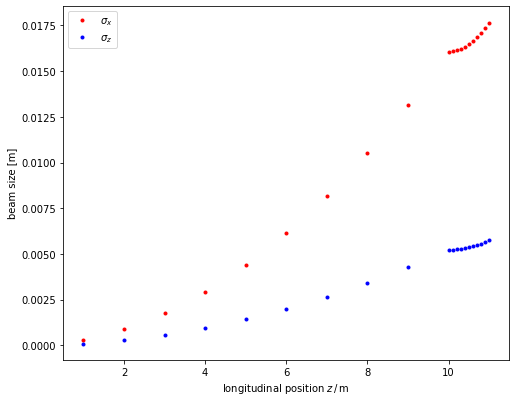

In [11]:
# plot stats.s vs sigmax, sigmaz
fig = plt.figure(figsize=(8,6.5))
ax = fig.gca()
ax.plot(stats.s, stats.sigmax,'r.', lw = 1, label = r'$\sigma_x$')
ax.plot(stats.s, stats.sigmaz,'b.', lw = 1, label = r'$\sigma_z$')
ax.set_xlabel(r'longitudinal position $z\,/\,\mathrm{m}$')
ax.set_ylabel(r'beam size [m]')
ax.legend()
# plt.xlim(0, 38)
# plt.ylim(0, 0.0012)
fig.show()

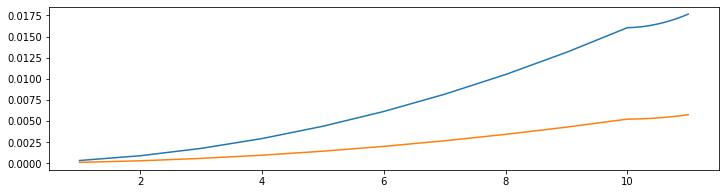

In [12]:
# this shows the beamline with no apertures applied
plt.figure(figsize=(12,3))
plt.plot(stats.s, stats.sigmax)
plt.plot(stats.s, stats.sigmaz)
plt.show()

In [13]:
sigma_mat

matrix([[ 3.11559151e+00,  5.14947686e-04, -4.79998642e-15,
         -6.53977329e-18],
        [ 5.14947686e-04,  8.51153199e-08, -7.93256229e-19,
         -1.08087279e-21],
        [-4.79997310e-15, -7.93254029e-19,  3.29536390e-01,
          5.44685178e-05],
        [-6.53977109e-18, -1.08087242e-21,  5.44685178e-05,
          9.00306079e-09]])